<h1>Data Analysis</h1>
<h2>Generative Data</h2>
This page is for analysis of the data and analysis of the model. First, we'll look at the distributions of the different components of data generation. First, we'll load the imports and Data Generator before we plot the distributions of each data generator component. 

In [3]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
import numpy as np
import enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

assert pyro.__version__.startswith('1.7.0')

class MovementType(enum.Enum):
    Sinusoidal = 1
    Linear2D = 2
    Linear3D = 3

class Args:
    def __init__(self):
        self.args = self.get_default_args()

    def get_default_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 0.8
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self 

    def get_prior_predictive_checks_args(self):
        self.num_frames = 5
        self.expected_num_objects = int(dist.Uniform(1, 5).sample())
        self.expected_num_spurious = float(int(dist.Uniform(1,3).sample()))
        self.max_num_objects = int(self.expected_num_objects + self.expected_num_spurious)
        self.emission_prob = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 3.)/4.))) #aiming for between [0.5,1.0]
        self.emission_noise_scale = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 2.)/4.))) #aiming for between [0.0,0.5]
        assert self.max_num_objects >= self.expected_num_objects
        print("Predictive check args. Num objects: ", self.expected_num_objects, " Num spurious: ", self.expected_num_spurious)
        print("Emission prob: ", self.emission_prob, " Noise scale: ", self.emission_noise_scale)
        return self


class DataGenerator:
    def __init__(self, movementType):
        print("Initializing DataGenerator with movement type ", movementType)
        self.movementType = movementType
        if self.movementType == MovementType.Sinusoidal:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear2D:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear3D:
            self.numDimensions = 3
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

    def get_dynamics(self, num_frames):
        if self.movementType == MovementType.Sinusoidal:
            time = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([time.cos(), time.sin()], -1)
        elif self.movementType == MovementType.Linear2D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y], -1)
        elif self.movementType == MovementType.Linear3D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            z = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y, z], -1)
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

        return dynamics

<h3>Position Distribution</h3>
The first distribution we will look at is the position distribution for a single object. 

Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([100, 1])
tensor([[-0.4400,  1.1277]])


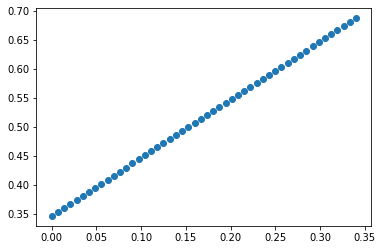

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 1
args.max_num_objects = 2

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
print(states)

plt.scatter(x,y)

Next, we will look at multiple objects. This shows that any trajectory with the offset we're using still passes through the center. If we wanted we could add an additional offset, as there will be association confusion when passing through the center. 

Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 80])
torch.Size([50, 80])
torch.Size([100, 80])


Text(0.5, 1.0, 'No offset')

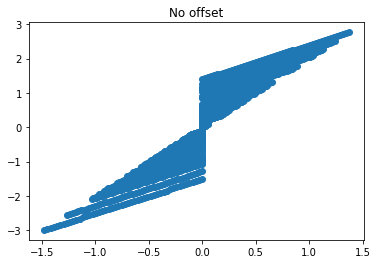

In [49]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 80
args.max_num_objects = 101

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
#print(states)

plt.scatter(x,y,cmap='jet')
plt.title("No offset")

Now I add an offset, and I'll plot a few lines so we can see them over the distribution.

torch.Size([100, 80])
torch.Size([80, 1])


Text(0.5, 1.0, 'With offset')

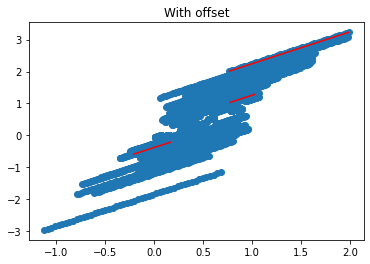

In [69]:
offsets = dist.Uniform(0., 1.).sample((args.expected_num_objects,1))
dynamics = dataGenerator.get_dynamics(args.num_frames)
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
positions = dynamics.mm(states.t())
positions = positions + offsets.t()

print(positions.shape)
print(offsets.shape)

x = positions[:50]
y = positions[50:]


plt.scatter(x,y,cmap='jet')
plt.plot(x[:,0],y[:,0],c='r')
plt.plot(x[:,30],y[:,30],c='r')
plt.plot(x[:,50],y[:,50],c='r')
plt.title("With offset")

X and Y states need to be separated

<h2>Prior Predictive Checks</h2>

In [176]:
def model(args):
    with pyro.plate("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                            dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.mask(mask=exists.bool()):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([args.num_dimensions]).to_event(1))
            positions = dataGenerator.get_dynamics(args.num_frames).mm(states.t())
    with pyro.plate("detections", args.expected_num_objects):
        with pyro.plate("time", args.num_frames):
            # The combinatorial part of the log prob is approximated to allow independence.
            spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,1))
            print("Spurious size: ", spurious.shape)
            print(spurious)
            emitted = dist.Bernoulli(args.emission_prob).sample((int(args.num_frames), int(args.expected_num_objects)))
            print("Visible size: ", emitted.shape)
            maxSpurious = int(max(spurious)[0])
            args.max_num_objects = int(args.expected_num_objects + maxSpurious)
            print(maxSpurious)
            spuriousVec = np.zeros((args.num_frames, maxSpurious))
            
            count = 0
            for i in spurious:
                spuriousVec[count,0:int(i[0])] = 1
                count = count + 1
                
            print(emitted)
            print(spuriousVec)
            emitted = torch.cat((emitted,torch.tensor(spuriousVec)), 1)
            print("After!")
            print(emitted)

            is_observed = (emitted > 0)
            with poutine.mask(mask=is_observed):
                assign = pyro.sample("assign",
                                    dist.Categorical(torch.ones(args.max_num_objects + 1)))
                
            allZerosSpurious = torch.tensor(np.zeros((args.num_frames, maxSpurious),dtype=int))
            print("Shapes")
            print(allZerosSpurious.shape)
            print(assign.shape)
            assign = torch.cat((assign, allZerosSpurious), 1)
            print("Assign: ", assign)
            is_spurious = np.zeros(emitted.shape, dtype=bool)
            is_spurious[:,int(args.expected_num_objects):] = (spuriousVec).astype(bool)
            is_spurious = torch.tensor(is_spurious)
            print("Is observed shape: ", is_observed.shape)
            print(type(is_observed))
            print("Is spurious shape: ", is_spurious.shape)
            print(type(is_spurious))
            print(is_spurious)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)
            print(num_observed)

            bernoulliRealProbs = args.expected_num_objects / num_observed
            bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
            pyro.sample("is_real",
                        dist.Bernoulli(bernoulliRealProbs))

            bernoulliSpuriousProbs = args.expected_num_spurious / num_observed
            bernoulliSpuriousProbs = np.clip(bernoulliSpuriousProbs, 0., 1.)
            pyro.sample("is_spurious",
                        dist.Bernoulli(bernoulliSpuriousProbs))

            # The remaining continuous part is exact.
            with poutine.mask(mask=is_real):
                bogus_position = positions.new_zeros(args.num_frames, 1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                
                print("Assign shape: ", assign.shape)
                print("Augmented shape: ", augmented_positions.shape)
                predicted_positions = gather(augmented_positions, assign, -1)
                pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale))
            with poutine.mask(mask=is_spurious):
                pyro.sample("spurious_observations", dist.Normal(0., 1.))

In [177]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2
model(args)
print(real_observations)

Spurious size:  torch.Size([5, 1])
tensor([[0.],
        [2.],
        [0.],
        [0.],
        [0.]])
Visible size:  torch.Size([5, 3])
2
tensor([[0., 0., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])
[[0. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
After!
tensor([[0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.]], dtype=torch.float64)
Shapes
torch.Size([5, 2])
torch.Size([5, 3])
Assign:  tensor([[3, 0, 1, 0, 0],
        [5, 0, 2, 0, 0],
        [5, 2, 5, 0, 0],
        [5, 5, 1, 0, 0],
        [4, 3, 2, 0, 0]])
Is observed shape:  torch.Size([5, 5])
<class 'torch.Tensor'>
Is spurious shape:  torch.Size([5, 5])
<class 'torch.Tensor'>
tensor([[False, False, False, False, False],
        [False, False, False,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, F

RuntimeError: index 5 is out of bounds for dimension 1 with size 5